# Natural Language Processing (NLP) training to identify scam messages from UC Irvine's data set

## Initial setup of Python libraries + defining functions

In [1]:
import pandas as pd
import numpy as np
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import pickle
import os
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from collections import Counter
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud
%matplotlib inline

def transform_message(message):
    # Remove punctuation
    message_not_punc = ''.join([char for char in message if char not in string.punctuation])
    
    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))  # Load stopwords only once
    message_clean = [word.lower() for word in message_not_punc.split() if word.lower() not in stop_words]
    
    return message_clean

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.show()

## Analysis of the UCI Dataset of Spam Messages

In [2]:
# Read the file using tab as the delimiter
data = pd.read_csv('Datasets/UCI_SPAM', sep='\t', header=None, names=["label", "message"])

# Clean up whitespace in the message column
data['message'] = data['message'].str.strip()

# Display the first rows
print(data.head())
data.describe()

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


,label,message
count,5572,5572
unique,2,5158
top,ham,"Sorry, I'll call later"
freq,4825,30


In [3]:
data["length"] = data["message"].apply(len)
data.sort_values(by='length', ascending=False).head(10)

,label,message,length
1085,ham,For me the love should start with attraction.i...,910
1863,ham,The last thing i ever wanted to do was hurt yo...,790
2434,ham,Indians r poor but India is not a poor country...,629
1579,ham,How to Make a girl Happy? It's not at all diff...,611
2849,ham,Sad story of a Man - Last week was my b'day. M...,588
2158,ham,Sad story of a Man - Last week was my b'day. M...,588
2380,ham,"Good evening Sir, hope you are having a nice d...",482
3017,ham,"&lt;#&gt; is fast approaching. So, Wish u a v...",461
1513,ham,"Hey sweet, I was wondering when you had a mome...",458
2370,ham,A Boy loved a gal. He propsd bt she didnt mind...,446


In [4]:
data.sort_values(by='length', ascending=False).tail(10)

,label,message,length
261,ham,Yup,3
4014,ham,Ok.,3
2182,ham,Ok.,3
1612,ham,645,3
3492,ham,Ok.,3
4498,ham,Ok,2
5357,ham,Ok,2
3376,ham,:),2
1925,ham,Ok,2
3051,ham,Ok,2


### Message Length Distribution by Label

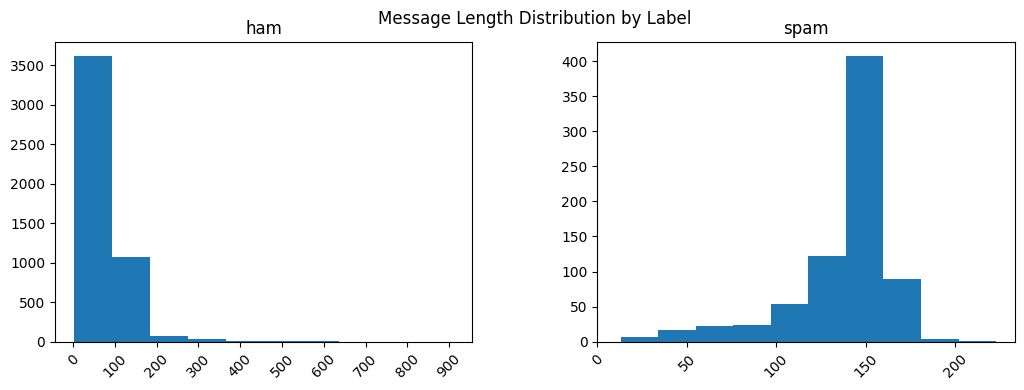

In [5]:
data.hist(column='length', by='label', figsize=(12, 4), bins=10)

plt.suptitle("Message Length Distribution by Label")  
plt.subplots_adjust(hspace=0.4)  

for ax in plt.gcf().axes:  
    x_min, x_max = ax.get_xlim()  
    tick_increment = 50  
    
    if x_max - x_min > 500:  
        tick_increment = 100
    elif x_max - x_min > 1000:
        tick_increment = 200

    x_ticks = np.arange(0, x_max + 1, tick_increment)  
    ax.set_xticks(x_ticks)  
    ax.tick_params(axis='x', rotation=45)  

plt.show()

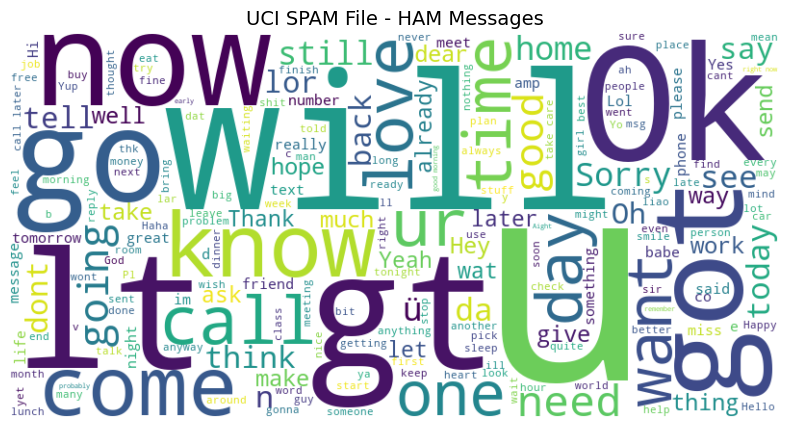

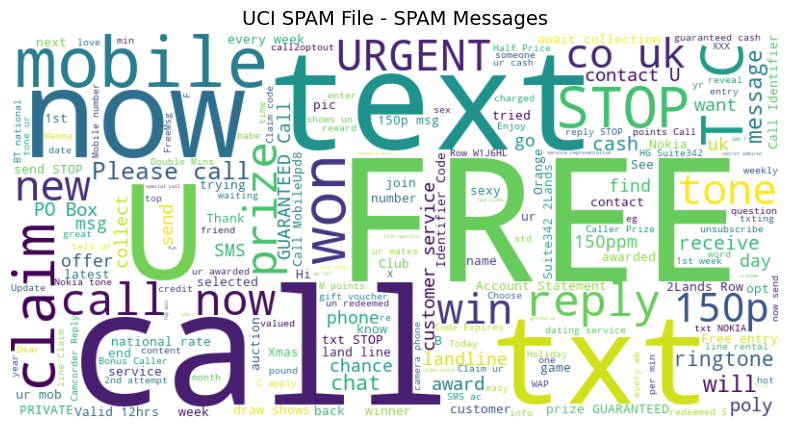

In [6]:
uci_ham = ' '.join(data[data.iloc[:, 0] == 'ham'].iloc[:, 1].dropna())
uci_spam = ' '.join(data[data.iloc[:, 0] == 'spam'].iloc[:, 1].dropna())

generate_wordcloud(uci_ham, 'UCI SPAM File - HAM Messages')
generate_wordcloud(uci_spam, 'UCI SPAM File - SPAM Messages')

## Vectorization of the spam messages

In [7]:
vectorization = CountVectorizer(analyzer=transform_message)

X = vectorization.fit_transform(data['message'])

# Display the shape of the resulting matrix
print(X.shape)

(5572, 9530)


In [8]:
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X)  # Fit and transform on the count matrix 'X'

# Print the shape of the TF-IDF matrix
print("TF-IDF Matrix Shape:", X_tfidf.shape)

TF-IDF Matrix Shape: (5572, 9530)


## Using Support Vector Classification (SVC) algorithm to train the NLP

In [9]:
# Correct target variable: 'label' column
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,                  # TF-IDF features
    data['label'],            # Target: ham or spam
    test_size=0.30,           # 30% for testing
    random_state=50           # Random seed for reproducibility
)

# Train the Support Vector Classifier (SVC)
clf = SVC(kernel='linear')    # Linear kernel SVM
clf.fit(X_train, y_train)

# Test the model
predictions = clf.predict(X_test)

# Display results
print("Classification Report:\n", classification_report(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))

Classification Report:
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1469
        spam       1.00      0.86      0.93       203

    accuracy                           0.98      1672
   macro avg       0.99      0.93      0.96      1672
weighted avg       0.98      0.98      0.98      1672

Confusion Matrix:
 [[1469    0]
 [  28  175]]


## Saving the model data

In [10]:
model_dir = 'Datasets/UCI_SPAM_Model'

with open(os.path.join(model_dir, 'vectorizer_dataset1.pkl'), 'wb') as vec_file:
    pickle.dump(vectorization, vec_file)

with open(os.path.join(model_dir, 'tfidf_transformer_dataset1.pkl'), 'wb') as tfidf_file:
    pickle.dump(tfidf_transformer, tfidf_file)

with open(os.path.join(model_dir, 'svm_model_dataset1.pkl'), 'wb') as model_file:
    pickle.dump(clf, model_file)

Model 1 Has No False Positives
    Observation: Model 1 did not misclassify any "ham" messages as "spam" (False Positives = 0).
    Implication: This indicates that Model 1 is conservative and avoids over-classifying messages as spam.
    Tradeoff: However, it missed 28 spam messages (False Negatives), meaning it sacrifices recall (sensitivity) to avoid False Positives.